In [1]:
# necessary imports
import helper.training_preprocess as tp
import helper.eval_worker as ew
from models.pibnn import PIBNN
import torch
import numpy as np

In [2]:
pinn_presaved = False
loss_params = {'ml': 0.7, 'physics': 0.3}
model_filename = "TEST_10k_HIGHNOISE_64H_pibnn_model_2024-12-15_17-24-44.pth"
model_fileprefix = "10k_0.5TRAJ_64H"

train_sensor_measurement_uncertainty = 1
train_epochs = 10000
training_traj_percent = 0.5

In [3]:
columns_of_interest_dict = tp.export_preproc_var_columns()
x_columns_of_interest = columns_of_interest_dict['x_columns_of_interest']
y_columns_of_interest = columns_of_interest_dict['y_columns_of_interest']

delta_time_columns = columns_of_interest_dict['delta_t_meas_columns']
x_meas_columns = columns_of_interest_dict['x_meas_columns']
v_meas_columns = columns_of_interest_dict['v_meas_columns']
z_obs_columns = columns_of_interest_dict['z_obs_columns']
additional_ml_features = columns_of_interest_dict['additional_ml_features'] 

In [5]:
%%time
train_df, test_df_holdout, train_traj_data, test_traj_data_holdout = tp.readin_dataframes(train_split=training_traj_percent, sensor_pos_uncer=train_sensor_measurement_uncertainty)

Number of Train Trajectories: 2547
Number of Test Trajectories: 2546
CPU times: total: 1min 19s
Wall time: 1min 19s


In [6]:
display(train_df)

,timestamp,tx,ty,tz,vx,vy,vz,tx_measured,ty_measured,tz_measured,vx_measured,vy_measured,vz_measured,sigma_pos,sigma_vel,tx_measured_plus,ty_measured_plus,tz_measured_plus,delta_time
0,0.000000,-20.110498,2.792424,17.071516,0.827515,-0.114170,0.334543,-21.611026,2.391436,16.381324,0.826959,-0.114212,0.336245,1,0.001,-19.828032,1.856141,17.862679,0.100000
1,0.100000,-20.027747,2.781007,17.104970,0.687851,-0.017778,0.435271,-19.828032,1.856141,17.862679,0.689375,-0.017539,0.435579,1,0.001,-18.371934,1.932200,17.462976,0.100000
2,0.200000,-19.958962,2.779229,17.148497,0.606798,0.254735,0.726220,-18.371934,1.932200,17.462976,0.607735,0.257501,0.727262,1,0.001,-19.157385,3.874234,16.791878,0.100000
3,0.300000,-19.898282,2.804703,17.221119,0.404264,0.639850,0.534433,-19.157385,3.874234,16.791878,0.403823,0.638685,0.534987,1,0.001,-21.732932,0.587965,17.748743,0.100000
4,0.400000,-19.857856,2.868688,17.274563,0.153350,1.112576,0.332398,-21.732932,0.587965,17.748743,0.153689,1.111830,0.333181,1,0.001,-18.564013,3.049962,16.696777,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396480,14.699986,4.355189,27.272745,12.449513,0.798235,-1.209915,-0.224657,5.883724,28.373502,11.329899,0.799059,-1.209972,-0.223771,1,0.001,3.642787,26.165980,13.724408,0.100000
396481,14.799986,4.435013,27.151753,12.427047,0.809838,-1.236443,-0.366748,3.642787,26.165980,13.724408,0.809373,-1.236651,-0.366901,1,0.001,5.668093,27.871432,12.765860,0.100000
396482,14.899986,4.515997,27.028109,12.390372,0.840176,-1.092647,-0.421202,5.668093,27.871432,12.765860,0.841135,-1.093343,-0.419992,1,0.001,5.636922,28.484863,10.658809,0.099999
396483,14.999986,4.600014,26.918844,12.348252,0.844423,-1.065764,-0.575578,5.636922,28.484863,10.658809,0.844833,-1.066495,-0.575009,1,0.001,4.815321,26.253815,14.135020,0.099999


In [7]:
display(test_df_holdout)

,timestamp,tx,ty,tz,vx,vy,vz,tx_measured,ty_measured,tz_measured,vx_measured,vy_measured,vz_measured,sigma_pos,sigma_vel,tx_measured_plus,ty_measured_plus,tz_measured_plus,delta_time
0,0.000000,-40.805557,-7.557310,16.847527,-3.592263,0.964076,0.089414,-40.867023,-7.526874,18.541413,-3.592604,0.964169,0.089601,1,0.001,-39.209163,-6.877028,16.625591,0.100000
1,0.100000,-41.164783,-7.460903,16.856468,-2.761677,0.770851,0.190097,-39.209163,-6.877028,16.625591,-2.762116,0.771251,0.189518,1,0.001,-40.388682,-6.589631,18.558480,0.100000
2,0.200000,-41.440951,-7.383818,16.875478,-2.402171,0.680947,0.580820,-40.388682,-6.589631,18.558480,-2.401588,0.681757,0.580544,1,0.001,-42.248153,-7.543787,17.402180,0.100000
3,0.300000,-41.681167,-7.315723,16.933560,-1.839856,0.252255,1.005508,-42.248153,-7.543787,17.402180,-1.839629,0.252828,1.007192,1,0.001,-42.761191,-6.864312,16.270852,0.100000
4,0.399999,-41.865152,-7.290498,17.034110,-1.630406,-0.376203,1.386813,-42.761191,-6.864312,16.270852,-1.628792,-0.377010,1.387763,1,0.001,-42.660903,-6.376168,16.800675,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74797,11.399989,-31.410724,-2.445097,5.099618,-2.817649,-2.408035,-0.115101,-31.376771,-1.490107,6.000418,-2.818196,-2.405788,-0.115301,1,0.001,-31.797576,-3.266774,3.274953,0.099999
74798,11.499989,-31.692487,-2.685899,5.088108,-2.732949,-2.156075,-0.068056,-31.797576,-3.266774,3.274953,-2.731822,-2.156873,-0.068578,1,0.001,-32.336632,-3.426699,5.648585,0.100000
74799,11.599989,-31.965783,-2.901507,5.081302,-3.040037,-2.226045,-0.004532,-32.336632,-3.426699,5.648585,-3.037222,-2.224969,-0.005116,1,0.001,-31.763283,-1.592474,4.147499,0.100000
74800,11.699989,-32.269788,-3.124112,5.080849,-2.856681,-1.939021,0.032186,-31.763283,-1.592474,4.147499,-2.856319,-1.938242,0.032143,1,0.001,-34.452411,-2.851320,3.876615,0.099999


In [8]:
# sanity check
print(len(train_df)/(len(test_df_holdout) + len(train_df)))

0.841281427240726


In [9]:
X_train, y_train, df_cleaned_train = tp.preprocess_and_remove_inter_trajectory_indices(train_df)
X_test, y_test, df_cleaned_test = tp.preprocess_and_remove_inter_trajectory_indices(test_df_holdout)

 Epoch: 10000/10000 | Loss:   4.18 

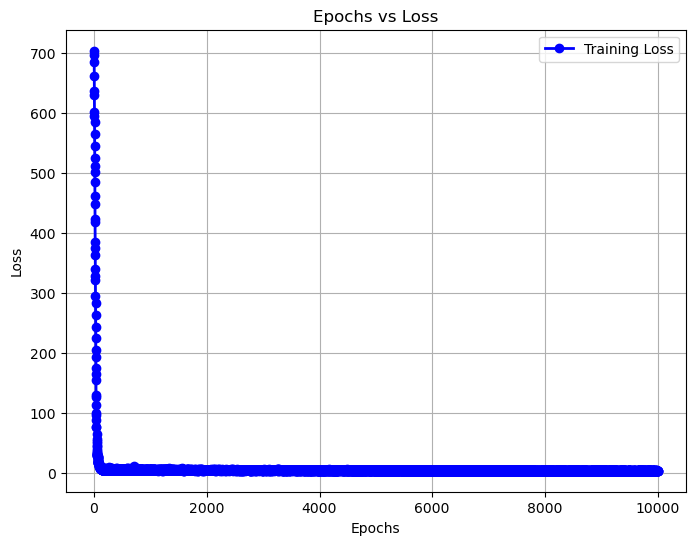

Model weights saved to ../../models/saved_weights/pibnn\10k_0.5TRAJ_64H_pibnn_model_2024-12-17_11-06-29.pth
CPU times: total: 6h 2min 23s
Wall time: 45min 56s


In [10]:
%%time
if pinn_presaved:
    pinn_model = PIBNN(input_size=8, output_size=len(y_columns_of_interest), hidden_layer_size=64, prior_sigma_lay=0.01, sensor_measurement_uncertainty=train_sensor_measurement_uncertainty, lambda_params=loss_params, epochs=train_epochs, bias_in=True)
    pinn_model.load_model_weights(f'../../models/saved_weights/pibnn/{model_filename}')
else:
    y_vel = torch.tensor(df_cleaned_train[['vx', 'vy', 'vz']][:-1].to_numpy(), dtype=torch.float32)
    x_meas = torch.tensor(df_cleaned_train[x_meas_columns][:-1].to_numpy(), dtype=torch.float32)
    v_meas = torch.tensor(df_cleaned_train[v_meas_columns][:-1].to_numpy(), dtype=torch.float32)
    dt_meas = torch.tensor(df_cleaned_train[delta_time_columns][:-1].to_numpy(), dtype=torch.float32)
    X_feature_space = torch.tensor(df_cleaned_train[additional_ml_features][:-1].to_numpy(), dtype=torch.float32)
    
    pinn_model = PIBNN(input_size=8, output_size=len(y_columns_of_interest), hidden_layer_size=64, prior_sigma_lay=0.01, sensor_measurement_uncertainty=train_sensor_measurement_uncertainty, lambda_params=loss_params, epochs=train_epochs, bias_in=True)
    
    pinn_model.fit(x_meas, v_meas, dt_meas, y_vel, X_feature_space, y_train)
    pinn_model.plot()
    pinn_model.save_model_weights(file_prefix=model_fileprefix, directory='../../models/saved_weights/pibnn')

In [11]:
z_obs_test = torch.tensor(df_cleaned_test[z_obs_columns][1:].to_numpy(), dtype=torch.float32)

In [12]:
print(z_obs_test.shape)
print(X_test.shape)

torch.Size([74293, 3])
torch.Size([74293, 12])


In [13]:
%%time
avg_pinn_model_err, avg_pinn_model_uncertainty, pinn_model_proposed_traj = ew.evaluate_bayesian_neural_model(pinn_model, df_cleaned_test, X_test, y_test, z_obs_test, pinn_eval=True, continuous_eval=True, apply_EKF_in=True)

100%|██████████| 74292/74292 [05:59<00:00, 206.94it/s]

CPU times: total: 47min 44s
Wall time: 5min 59s


In [14]:
print(f"AVG Error: {np.mean(avg_pinn_model_err)}")
print(f"AVG Uncertainty: {np.mean(avg_pinn_model_uncertainty)}")

AVG Error: 1.8936353985065524
AVG Uncertainty: 0.15280677232011378
